# Fraud detection dataset
Fraud detection dataset is an example dataset from kaggle.com analyzed for educational purposes. 

## Imports and settings

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.inspection import PartialDependenceDisplay
import shap

# Setting jupyter display settings, so that it doesn't hide any columns
pd.set_option('display.max_columns', None) 

## General overview of dataset

In [2]:
# Import and view dataset
fraud = pd.read_csv('fraud_detection_bank_dataset.csv')
print(fraud.head())
print(fraud.shape)

   Unnamed: 0  col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  col_8  \
0           0      9   1354      0     18      0      1      7      9      0   
1           1      0    239      0      1      0      1      0      0      0   
2           2      0    260      0      4      0      3      6      0      0   
3           3     17    682      0      1      0      0      8     17      0   
4           4      1    540      0      2      0      1      7      1      0   

   col_9  col_10  col_11  col_12  col_13  col_14  col_15  col_16  col_17  \
0      0       0       0       0       0       1       0       1       0   
1      0       0       0       0       0       0       0       1       0   
2      0       0       0       0       0       1       1       0       0   
3      0       0       0       0       0       0       0       1       0   
4      0       0       0       0       0       1       0       1       0   

   col_18  col_19  col_20  col_21  col_22  col_23  col_24  col

In [3]:
# Display general information on each column
print(fraud.describe())

         Unnamed: 0         col_0         col_1         col_2         col_3  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.000000   
mean   10233.500000      3.226256    294.793043      0.420021      2.329343   
std     5908.746991     20.564308    717.541984      7.367275     10.068512   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     5116.750000      0.000000     38.000000      0.000000      0.000000   
50%    10233.500000      0.000000     97.000000      0.000000      1.000000   
75%    15350.250000      2.000000    283.000000      0.000000      2.000000   
max    20467.000000   2301.000000  37808.000000    904.000000    772.000000   

              col_4         col_5         col_6         col_7    col_8  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.0   
mean       0.083594      0.939857      2.386066      3.226256      0.0   
std        0.840537      4.222896      3.018140     20.564308     

Dataset has over 20K records and 114 columns. First column ("Unnamed: 0") is just record ID and is unnecessary for this analysis. Last column is our target value determining whether a transaction was a fraud (1) or not (0). Column names are not desriptive so it can be challenging to interpret feature importance and identify redundant features. Nevertheless we can still reduce dimentionality of this dataset. There are few columns that has always the same value (ex. 'col_8'). We can remove those columns because they do not provide any information for predicting target value. 

## Feature exploration

### Dropping redundant columns

In [4]:
# Dropping column with indexes
fraud = fraud.drop('Unnamed: 0', axis=1)

# Dropping columns where all values are zeros
fraud_no_zeros = fraud.loc[:, (fraud != 0).any(axis=0)]
print(fraud_no_zeros.describe())

              col_0         col_1         col_2         col_3         col_4  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.000000   
mean       3.226256    294.793043      0.420021      2.329343      0.083594   
std       20.564308    717.541984      7.367275     10.068512      0.840537   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000     38.000000      0.000000      0.000000      0.000000   
50%        0.000000     97.000000      0.000000      1.000000      0.000000   
75%        2.000000    283.000000      0.000000      2.000000      0.000000   
max     2301.000000  37808.000000    904.000000    772.000000     54.000000   

              col_5         col_6         col_7        col_13        col_14  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.000000   
mean       0.939857      2.386066      3.226256      0.038646      0.363152   
std        4.222896      3.018140     20.564308    

Number of columns from 114 to 98. 

### Correlation

<Axes: >

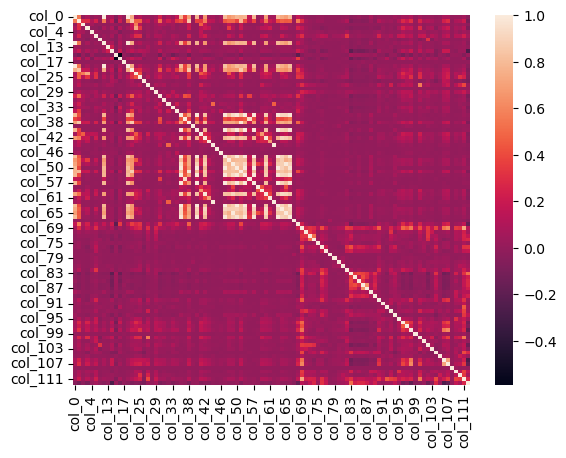

In [5]:
# Show correlation heatmap
corr = fraud_no_zeros.corr()
sns.heatmap(corr)

There are many columns that are highly correlated and they will not bring much value to the prediction. Let's keep only the one that is mostly correlated to target value.

In [6]:
# Extract columns that are highly correlated to 'col_0' - chosen based on heatmap
cols_to_drop = corr[corr['col_0']>0.7].index.values
print("Column highly correlated: ")
print(cols_to_drop)

# Extract feature from list that is mostly correlated to target column
col_most_corr_to_target = corr.loc['targets',cols_to_drop].sort_values().index[0]
print("Column most correlated to target column from list of highly correlated columns: " + col_most_corr_to_target)

# Droping the list of highly correated column with exception of one column that is the most correated to target
cols_to_drop = np.delete(cols_to_drop, np.where(cols_to_drop == col_most_corr_to_target))
fraud_reduced = fraud_no_zeros.drop(cols_to_drop ,axis=1)
print(fraud_reduced.shape)

Column highly correlated: 
['col_0' 'col_7' 'col_22' 'col_23' 'col_36' 'col_40' 'col_47' 'col_49'
 'col_50' 'col_54' 'col_55' 'col_57' 'col_63' 'col_64' 'col_66']
Column most correlated to target column from list of highly correlated columns: col_23
(20468, 84)


<Axes: >

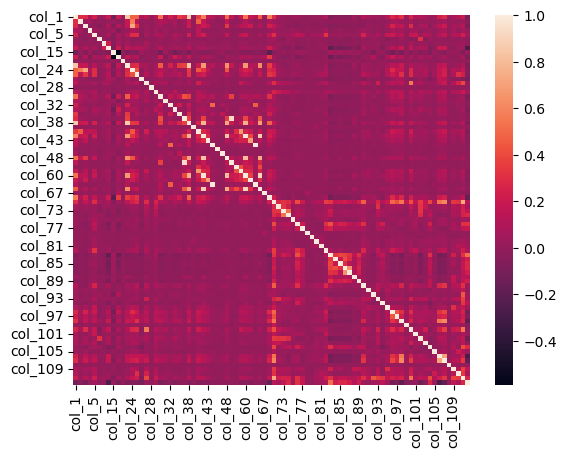

In [7]:
# Show correlation heatmap after removing highly correlated columns
corr2 = fraud_reduced.corr()
sns.heatmap(corr2)

Now let's check for high correlation between features and target values.
If we have in our dataset features highly correlated to target values then we can expect that our predictions will be very accurate and mostly based on this feature. It can also mean that creating a prediction model is unnecesary and one 'if' condition can solve our classification problem.

In [8]:
# Display list of features with correlation to target over 0.6
cols_with_high_corr_to_target = corr2[corr2['targets']>0.6].index.values
print(cols_with_high_corr_to_target)

['targets']


### Data types

Let's check what data types we have and split the data into numerical and categorical data. It would be hard to find categorical data with multiple classes since we don't have any explanation, so for the time being let's focus only on binary features.

In [9]:
# Display Dtypes of columns
print(fraud_reduced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 84 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   col_1    20468 non-null  int64  
 1   col_2    20468 non-null  int64  
 2   col_3    20468 non-null  int64  
 3   col_4    20468 non-null  int64  
 4   col_5    20468 non-null  int64  
 5   col_6    20468 non-null  int64  
 6   col_13   20468 non-null  int64  
 7   col_14   20468 non-null  int64  
 8   col_15   20468 non-null  int64  
 9   col_16   20468 non-null  int64  
 10  col_17   20468 non-null  int64  
 11  col_23   20468 non-null  int64  
 12  col_24   20468 non-null  int64  
 13  col_25   20468 non-null  int64  
 14  col_26   20468 non-null  int64  
 15  col_27   20468 non-null  int64  
 16  col_28   20468 non-null  int64  
 17  col_29   20468 non-null  int64  
 18  col_30   20468 non-null  int64  
 19  col_31   20468 non-null  int64  
 20  col_32   20468 non-null  int64  
 21  col_33   204

In [10]:
# Split dataset to numerical and binary features
binary = pd.DataFrame()
numerical = pd.DataFrame()
for col in fraud_reduced.columns:
    if fraud_reduced[col].min() == 0 and fraud_reduced[col].max() == 1:
        binary[col] = fraud_reduced[col]
    else: 
        numerical[col] = fraud_reduced[col]
print(binary.shape)
print(numerical.shape)

(20468, 42)
(20468, 42)


We have 42 binary columns and 42 numerical columns in our dataset. 

### Distribution and variance

In [11]:
# Display general information on each column
print(numerical.describe())

              col_1         col_2         col_3         col_4         col_5  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.000000   
mean     294.793043      0.420021      2.329343      0.083594      0.939857   
std      717.541984      7.367275     10.068512      0.840537      4.222896   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       38.000000      0.000000      0.000000      0.000000      0.000000   
50%       97.000000      0.000000      1.000000      0.000000      0.000000   
75%      283.000000      0.000000      2.000000      0.000000      1.000000   
max    37808.000000    904.000000    772.000000     54.000000    230.000000   

              col_6         col_17        col_23        col_24        col_25  \
count  20468.000000   20468.000000  20468.000000  20468.000000  20468.000000   
mean       2.386066     196.679500     34.201290      3.068790      2.701925   
std        3.018140    6700.095223    126.109375

Some features are almost entirely zeros. Let's check how many.

In [12]:
# Split numerical dataframe on features that are mostly zeros
most_zeros = pd.DataFrame()
not_zeros = pd.DataFrame()
for col in numerical.columns:
    if np.percentile(numerical[col], 75)==0:
        most_zeros[col] = numerical[col]
    else:
        not_zeros[col] = numerical[col]
print(most_zeros.shape)
print(not_zeros.shape)

(20468, 27)
(20468, 15)


We can see that in this dataset there are plenty outliers. Good practice would be to give them a closer look. Since there is not enough information about features, outliers will not be removed. They can contain some cruitial information and since it is not one or two values, but plenty, we can assume that it is correct feature distribution. 

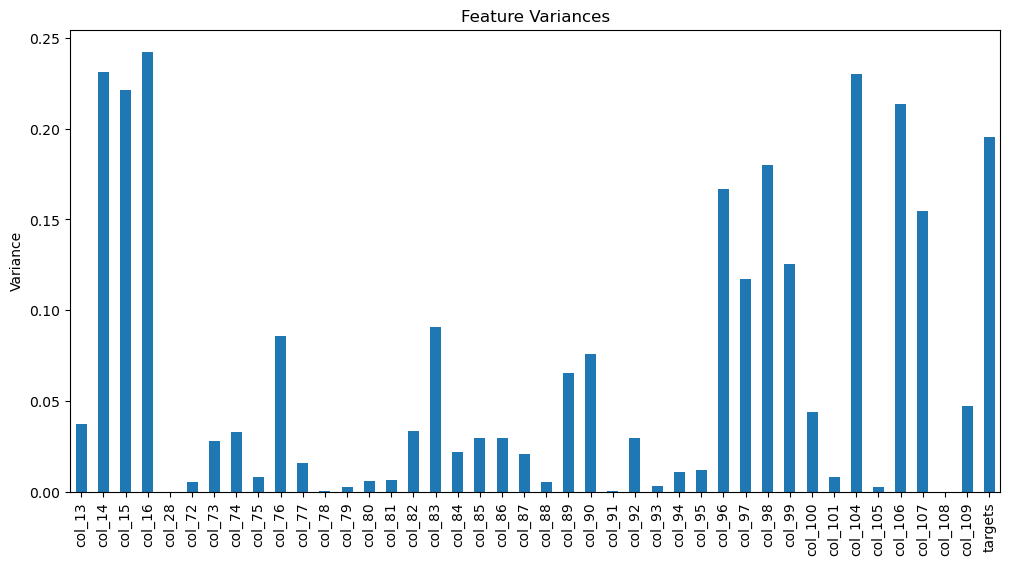

In [13]:
# Calculate variance of binary features
bin_variances = binary.var()

# Plot the variance of binary features
plt.figure(figsize=(12, 6))
bin_variances.plot(kind="bar")
plt.title("Feature Variances")
plt.ylabel("Variance")
plt.show()

For binary features variance is quite similar, except for few columns with very small variance. Let's check why.

In [14]:
fraud_reduced['col_28'].value_counts()

col_28
1    20467
0        1
Name: count, dtype: int64

Column 'col_28' has variance close to 0 because only one record has this feature. Since we do't know what it represents it is better to keep it.

col_1      5.148665e+05
col_2      5.427674e+01
col_3      1.013749e+02
col_4      7.065017e-01
col_5      1.783285e+01
col_6      9.109166e+00
col_17     4.489128e+07
col_23     1.590357e+04
col_24     1.630340e+02
col_25     2.056505e+02
col_26     2.382040e+01
col_27     9.974635e-02
col_29     8.759652e+00
col_30     4.896366e+02
col_31     2.842702e+00
col_32     3.408692e+01
col_33     8.282123e-02
col_34     3.344500e+02
col_37     2.280191e+03
col_38     6.172543e+05
col_39     8.008688e-03
col_41     1.765910e+01
col_42     3.373495e+03
col_43     1.309650e+01
col_44     3.494698e+02
col_45     3.195069e+00
col_46     6.404742e-01
col_48     1.615166e+03
col_56     3.882225e+02
col_58     5.083056e-01
col_59     4.681646e+00
col_60     2.944617e+03
col_61     9.585286e+00
col_62     3.267348e+02
col_65     6.289294e+04
col_67     1.406312e+11
col_68     7.499842e+03
col_69     6.999202e+00
col_102    3.122711e-01
col_103    5.399014e-03
col_110    9.307333e-02
col_111    3.506

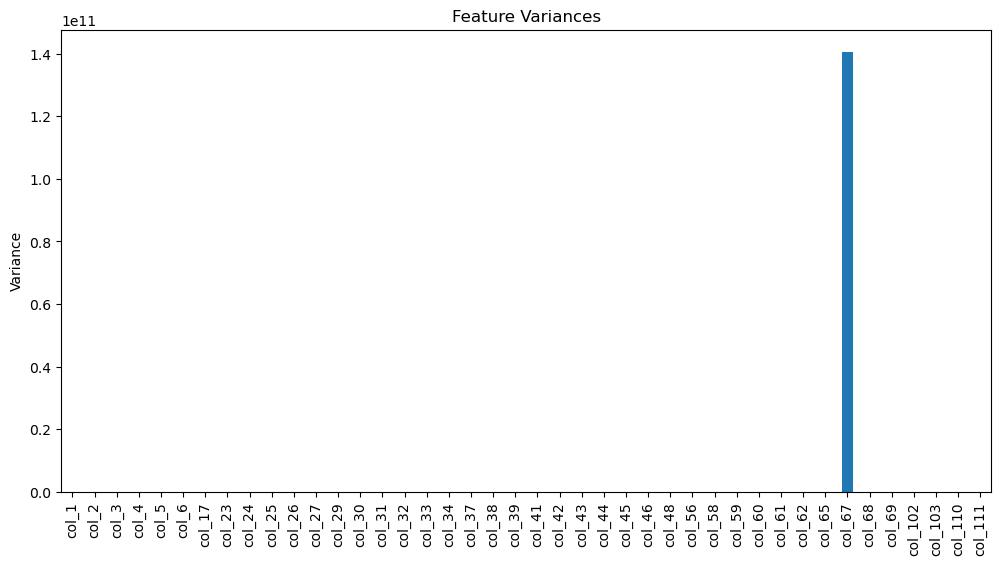

In [15]:
# Calculate variance of numerical features
num_variances = numerical.var()
print(num_variances)
# Plot the variance of numerical features
plt.figure(figsize=(12, 6))
num_variances.plot(kind="bar")
plt.title("Feature Variances")
plt.ylabel("Variance")
plt.show()

Numerical values have different variances. It is hard to visualize them on one plot, because some values are extremely large. Let's check if it is one outlier or more observations.

In [16]:
numerical['col_67'].value_counts()

col_67
0.000000         10491
209.000000           5
57.000000            4
407.000000           4
618.500000           3
                 ...  
547.555556           1
203216.285714        1
149457.906977        1
32323.487952         1
1163.329545          1
Name: count, Length: 9743, dtype: int64

Column 'col_67' has multiple large values and multiple zeros. That's why variance is so high. Let's check also one column with extremey low variance.

In [17]:
numerical['col_39'].value_counts()

col_39
0    20443
1       21
9        1
3        1
7        1
2        1
Name: count, dtype: int64

In column 'col_39' almost all values are zeros, but those 25 observations that are not zeros can hold important information about our target value. Let's keep it.

## Preprocessing data

In [18]:
# Extract features
X = fraud_reduced.drop('targets', axis=1)
print(X.shape)
# Extract target
y = fraud_reduced['targets']
print(y.shape)
# Split the data for train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    

(20468, 83)
(20468,)


### Dataset balance

It is important to know if target values has even distribution between classes. Some machine learning algorithms can't predict correctly when trained on imbalanced dataset. Fortunately there are some ways to go around it. One of them is SMOTE function, that generates more observation to less numerous classes.

In [19]:
# Display the class distribution before applying SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Display the class distribution after applying SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train).value_counts())

Class distribution before SMOTE:
targets
0    12024
1     4350
Name: count, dtype: int64

Class distribution after SMOTE:
targets
0    12024
1    12024
Name: count, dtype: int64


We had less fraudant transactions in this dataset, so SMOTE function created more, so that there is equal amount of fraudant and regular transactions.

## Training a model

For looking for fraudant transaction we can choose Logistic Regression. It is quite accurate and rather quickly calculated and simple. Also results remains interpretable. As a result we get probability, so we can still decide on the threshold for classification.

Before fitting the model, features should be scaled with StandardScaler so that they are compareable and their values has equal impact on training. Also there are still 83 columns. We can reduce their number and the noise within each with dimention reduction techniques such as PCA. So for this dataset there will be a pipeline with StandardScaler, PCA and finaly LogisticRegression. 

For better results we can use hyperparameter tuning methods. Package Optuna is dedicated to try multiple versions of hyperparameters, choosing the best ones. It is designed in a way that finds global maximum or minimum without stucking in local one.
In this case Optuna will suggest best number of components in PCA and C, solver and max_iter for LogisticRegression.

In [20]:
# Define an objective function for Optuna
def objective(trial):
    scaler = StandardScaler()
    pca = PCA(n_components=trial.suggest_int("pca_components", 10, X_train.shape[1]))

    # Create the pipeline with StandardScaler, PCA and the classifier
    lr_pipeline = Pipeline([
        ("scaler", scaler),
        ("pca", pca),
        ("classifier", LogisticRegression(
            C=trial.suggest_loguniform("C", 1e-5, 1e5),
            solver= trial.suggest_categorical("solver", ["liblinear", "lbfgs"]), # tested also 'saga', but it gives bad results and runs out of iterations
            max_iter= trial.suggest_int("max_iter", 500, 5000),
            random_state=42
        ))
    ])

    # Calculate ROC AUC score using cross-validation
    lr_roc_auc = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring="roc_auc").mean()

    # Return the negative ROC AUC score as Optuna minimizes the objective
    return -lr_roc_auc

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the hyperparameters
study.optimize(objective, n_trials=100) # For better results increase, for faster run decrease

# Get the best parameters from the study
best_params = study.best_trial.params

# Build the final pipeline with the best hyperparameters
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=best_params["pca_components"])),
    ("classifier", LogisticRegression(
        C=best_params["C"],
        solver=best_params['solver'],
        max_iter=best_params['max_iter'],
        random_state=42
    ))
])

# Train and evaluate the final pipeline
final_pipeline.fit(X_train, y_train)
X_test_pca = final_pipeline.named_steps['pca'].transform(final_pipeline.named_steps['scaler'].transform(X_test))

y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba)

print("Logistic Regression ROC AUC on test set:", roc_auc_test)

[I 2023-12-09 13:23:53,306] A new study created in memory with name: no-name-d72e5db7-7987-4e01-b939-870d1e456907
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:23:55,070] Trial 0 finished with value: -0.9155307409937496 and parameters: {'pca_components': 29, 'C': 574.0242886699482, 'solver': 'lbfgs', 'max_iter': 3785}. Best is trial 0 with value: -0.9155307409937496.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:24:00,693] Trial 1 finished with value: -0.9630129498267148 and parameters: {'pca_components': 82, 'C': 18.603931534917646, 'solver': 'lbfgs', 'max_iter': 2076}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. T

[I 2023-12-09 13:25:18,373] Trial 19 finished with value: -0.9525047822168352 and parameters: {'pca_components': 73, 'C': 148.04668060455086, 'solver': 'lbfgs', 'max_iter': 2769}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:25:19,526] Trial 20 finished with value: -0.9051854998290843 and parameters: {'pca_components': 13, 'C': 4.15318090201286, 'solver': 'lbfgs', 'max_iter': 1654}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:25:23,846] Trial 21 finished with value: -0.9628627616625028 and parameters: {'pca_components': 83, 'C': 342.458358559519, 'solver': 'lbfgs', 'max_

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
[I 2023-12-09 13:26:45,105] Trial 37 finished with value: -0.9580185257660846 and parameters: {'pca_components': 75, 'C': 23727.015729978837, 'solver': 'lbfgs', 'max_iter': 2073}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:31:05,306] Trial 38 finished with value: -0.9577379941011864 and parameters: {'pca_components': 76, 'C': 2871.120684107205, 'solver': 'liblinear', 'max_iter': 820}. Best is trial 1 with val

[I 2023-12-09 13:33:21,042] Trial 55 finished with value: -0.9583140477263093 and parameters: {'pca_components': 77, 'C': 332.56933883853105, 'solver': 'lbfgs', 'max_iter': 1264}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:33:48,985] Trial 56 finished with value: -0.9524109676660416 and parameters: {'pca_components': 73, 'C': 59.035975171907275, 'solver': 'liblinear', 'max_iter': 1999}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:33:53,498] Trial 57 finished with value: -0.9616373837369683 and parameters: {'pca_components': 81, 'C': 26.40603446745595, 'solver': 'lbfgs'

[I 2023-12-09 13:37:31,223] Trial 75 finished with value: -0.9596453309516706 and parameters: {'pca_components': 79, 'C': 237.45291480333302, 'solver': 'lbfgs', 'max_iter': 2472}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:37:32,577] Trial 76 finished with value: -0.9121492290850636 and parameters: {'pca_components': 22, 'C': 4139.402156114943, 'solver': 'lbfgs', 'max_iter': 4032}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:37:37,566] Trial 77 finished with value: -0.9616681568599198 and parameters: {'pca_components': 81, 'C': 503.9676121486633, 'solver': 'lbfgs', 'ma

[I 2023-12-09 13:39:16,861] Trial 91 finished with value: -0.9628593725728922 and parameters: {'pca_components': 83, 'C': 1165.0024583358836, 'solver': 'lbfgs', 'max_iter': 1660}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:39:22,955] Trial 92 finished with value: -0.962786902168238 and parameters: {'pca_components': 82, 'C': 1890.4997117204582, 'solver': 'lbfgs', 'max_iter': 1481}. Best is trial 1 with value: -0.9630129498267148.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-09 13:39:28,097] Trial 93 finished with value: -0.9616863451309439 and parameters: {'pca_components': 81, 'C': 903.7362244374713, 'solver': 'lbfgs', 'ma

Logistic Regression ROC AUC on test set: 0.9323635205080035


Each time the result will be slitely different. Best ROC AUC score achived was 0.96 on training set and 0.93 on test set.
Best hyperparameters:
pca_components: 82, 
C: 18.603931534917646,
solver: 'lbfgs',
max_iter: 2076
We can consider removing PCA from the pipeline since it seems insignificant for model quality, but we loose interpretability.

In [29]:
# Training model to compare same parameters without PCA
final_pipeline_no_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(
        C=18.6,
        solver='lbfgs',
        max_iter=2076,
        random_state=42
    ))
])
final_pipeline_no_pca.fit(X_train, y_train)

y_pred_proba_no_pca = final_pipeline_no_pca.predict_proba(X_test)[:, 1]
roc_auc_test_no_pca = roc_auc_score(y_test, y_pred_proba_no_pca)

print("Logistic Regression ROC AUC on test set:", roc_auc_test_no_pca)

Logistic Regression ROC AUC on test set: 0.9320363562091503


As we can see the result is almost identical. For business purposes this is better model, but for educational purposes let's analyze further the one with PCA.

## Evaluating model

### Confusion matrix

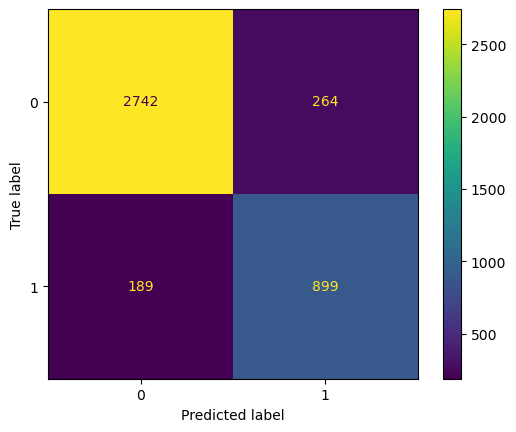

In [21]:
# Display confusion matrix
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

As we can see there are o lot of frauds that were not detected. In this case we can have more transactions wrongly classfied as fraudant (false positives), because they can be checked manualy. Most important is to have as few missed frauds (false negatives) as possible. To impove this score we can decrease the threshold. 

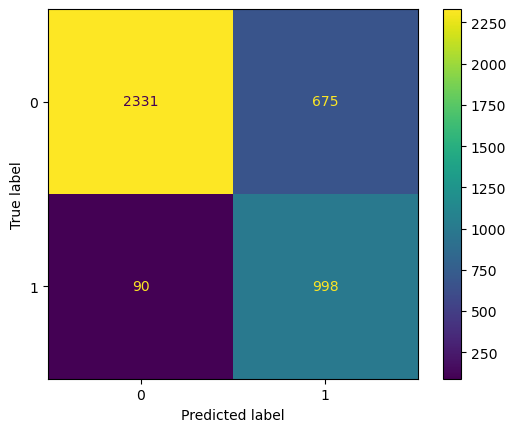

In [22]:
# Display confusion matrix with smaller threshold
threshold = 0.25
y_pred = (y_pred_proba > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### SHAP values

In [23]:
# Function to use for SHAP values
def predict_function(X):

    # Make predictions using the classifier
    return final_pipeline.named_steps['classifier'].predict_proba(X)[:, 1]

# Transform the features using the same pipeline
X_transformed = final_pipeline.named_steps['pca'].transform(final_pipeline.named_steps['scaler'].transform(X_test))

# Explain the model using SHAP values
explainer = shap.Explainer(predict_function, X_transformed)
shap_values = explainer.shap_values(X_transformed)


PermutationExplainer explainer: 4095it [04:19, 15.37it/s]                          


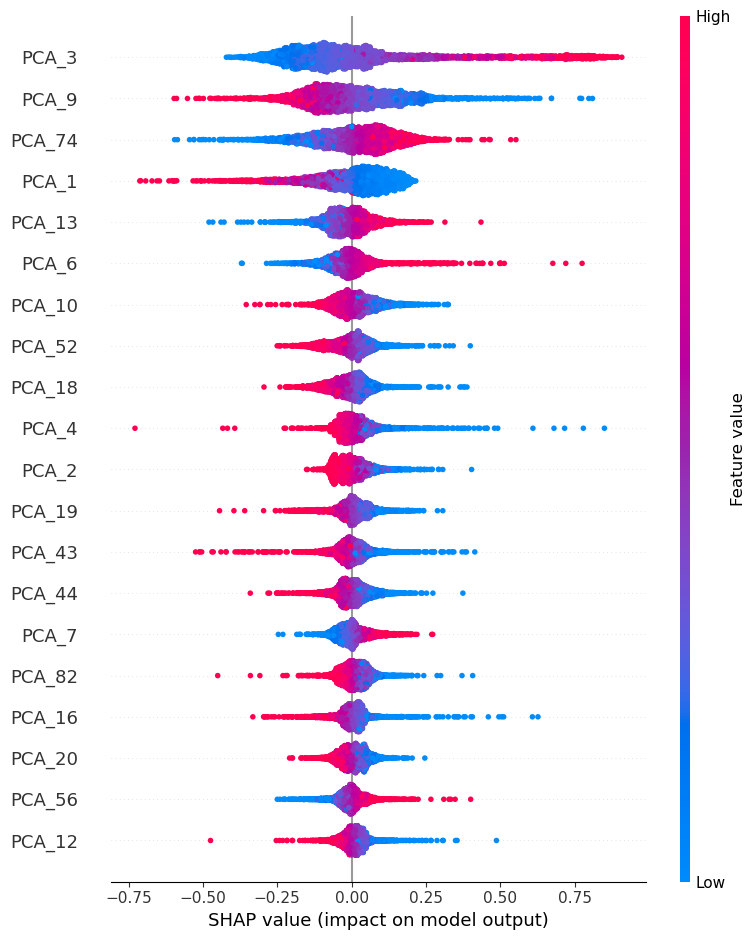

In [24]:
# Display SHAP values summary plot
feature_names_pca = [f"PCA_{i}" for i in range(1, final_pipeline.named_steps['pca'].n_components_ + 1)]
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names_pca)

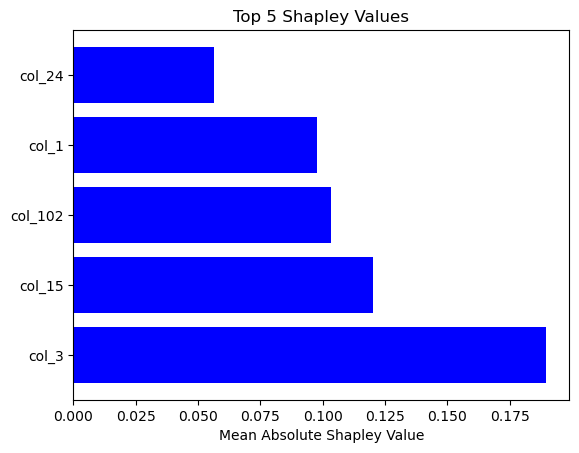

In [25]:
# Calculate the absolute mean Shapley values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Get the indices of the top 5 features
top_feature_indices = mean_abs_shap_values.argsort()[-5:][::-1]

# Get the top 5 feature names and Shapley values
top_feature_names = X.columns[top_feature_indices]
top_shap_values = mean_abs_shap_values[top_feature_indices]

# Plot the top 5 Shapley values
plt.barh(top_feature_names, top_shap_values, color="blue")
plt.xlabel("Mean Absolute Shapley Value")
plt.title("Top 5 Shapley Values")
plt.show()

### Dependence plot

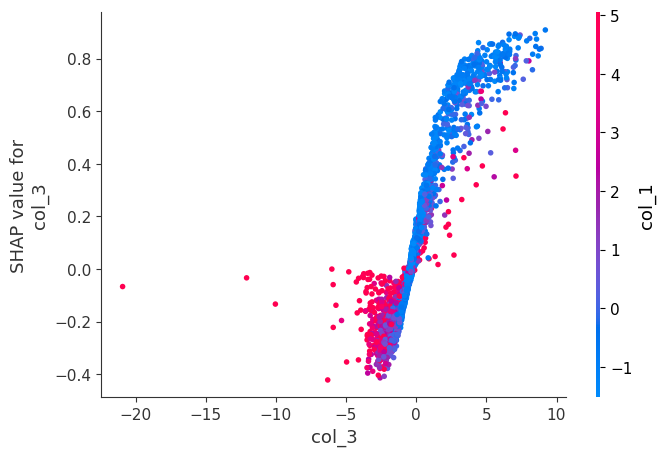

In [26]:
# Display dependence plot
feature_names = X.columns.tolist()
col_name = X.columns[mean_abs_shap_values.argsort()[-1:][::-1]].values[0]
shap.dependence_plot(col_name, shap_values, X_transformed, feature_names = feature_names)

### Partial dependence plot

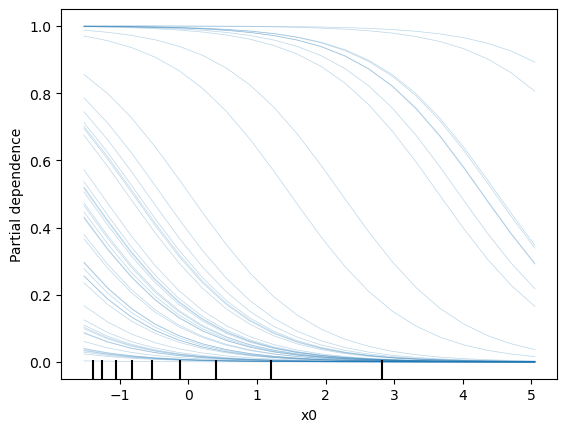

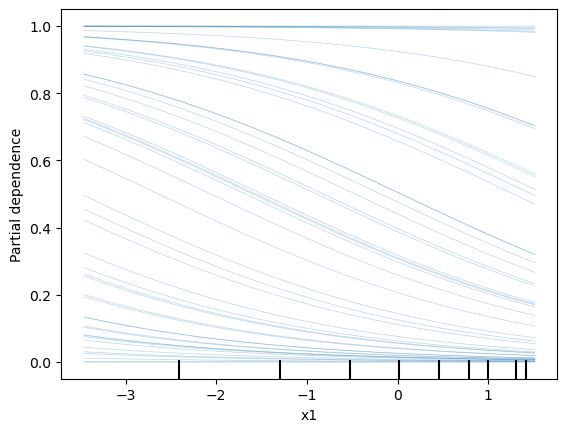

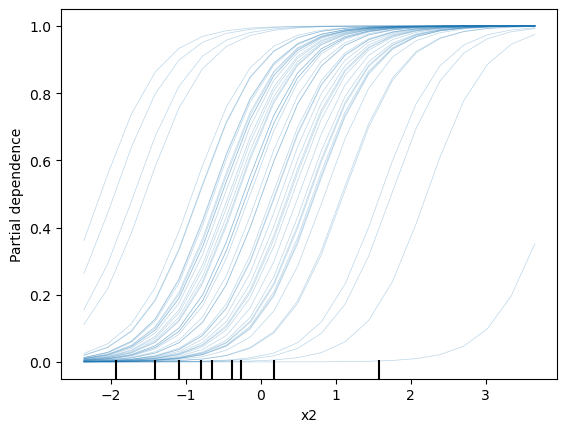

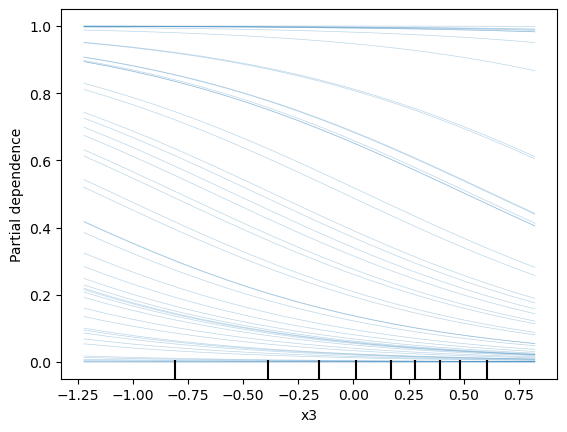

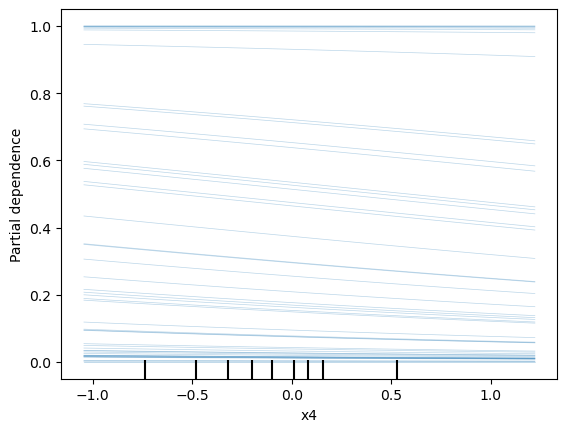

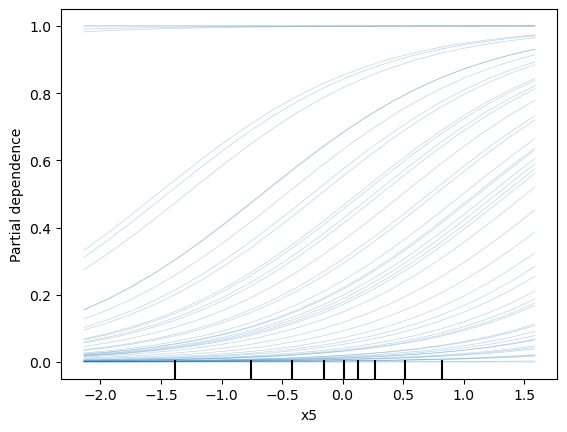

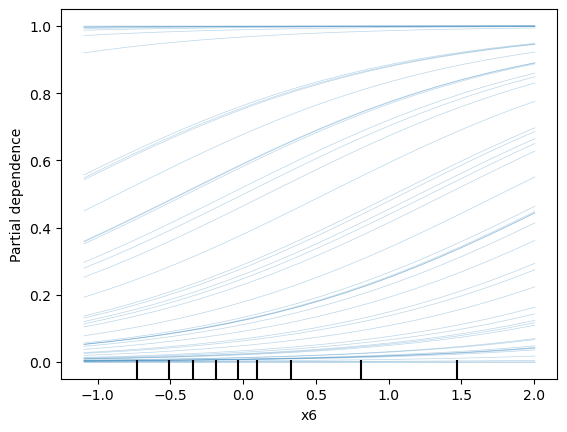

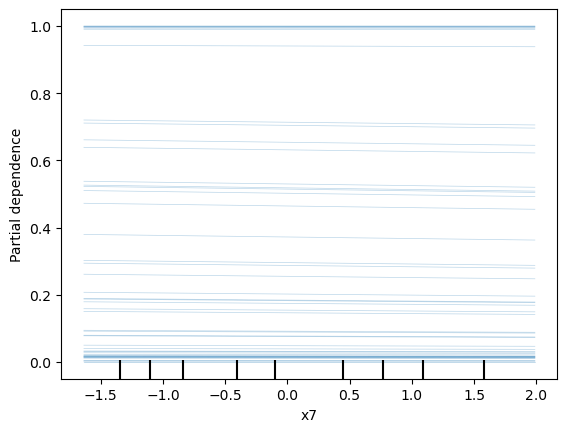

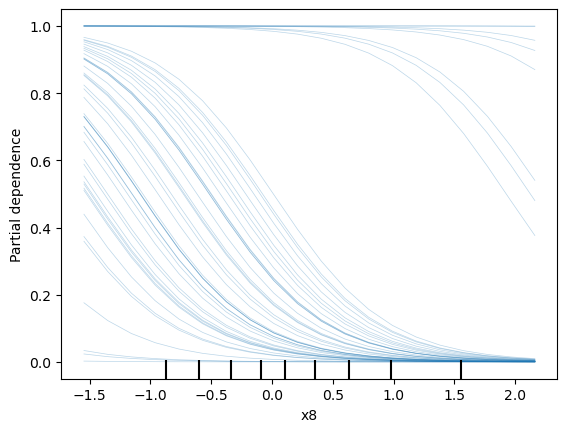

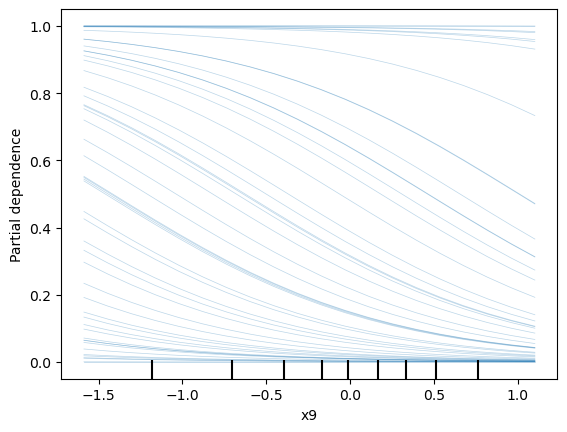

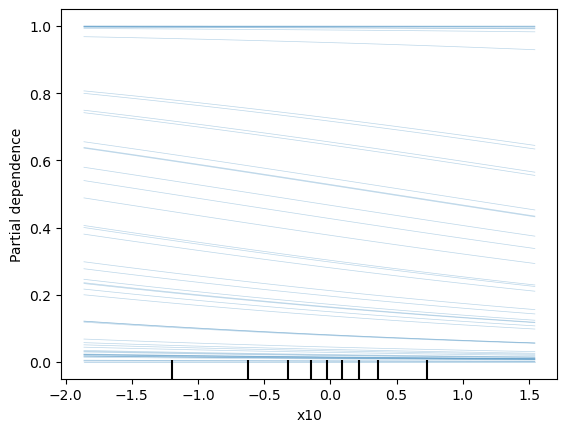

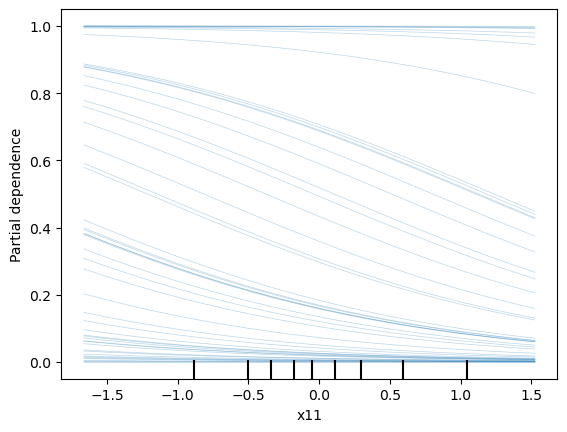

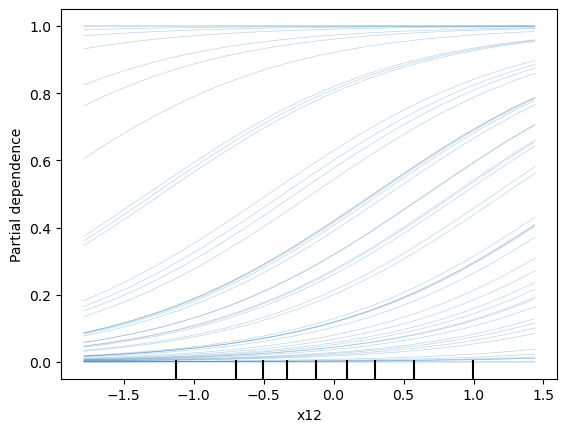

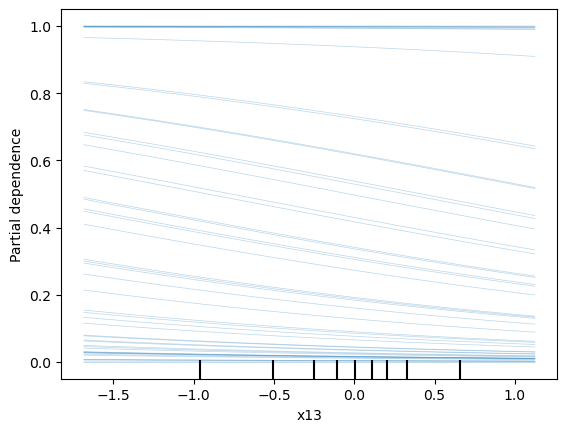

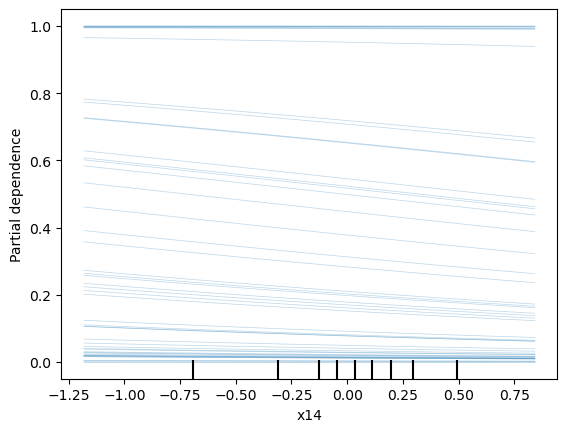

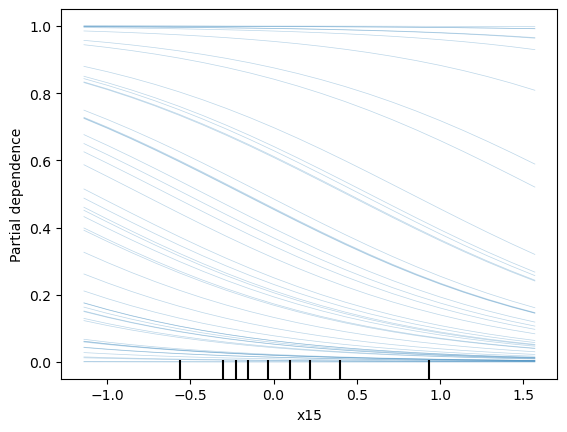

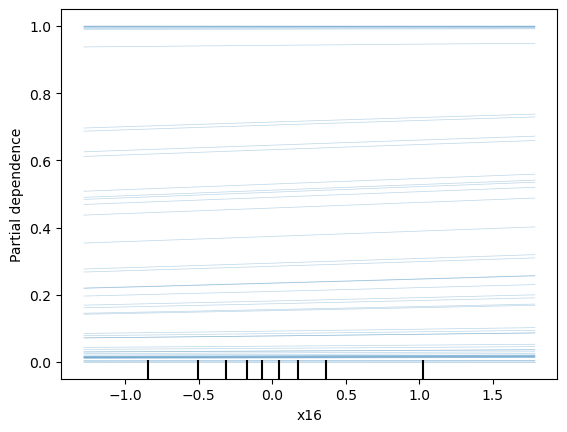

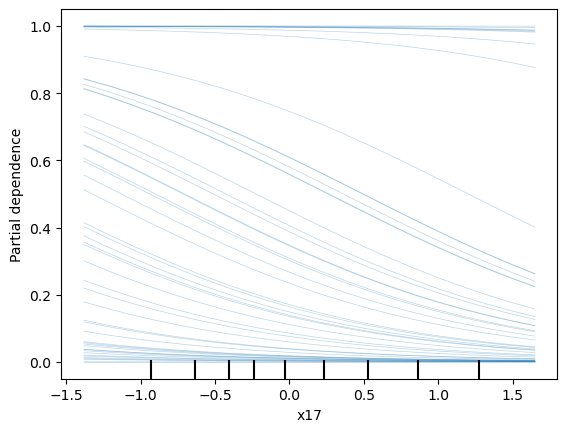

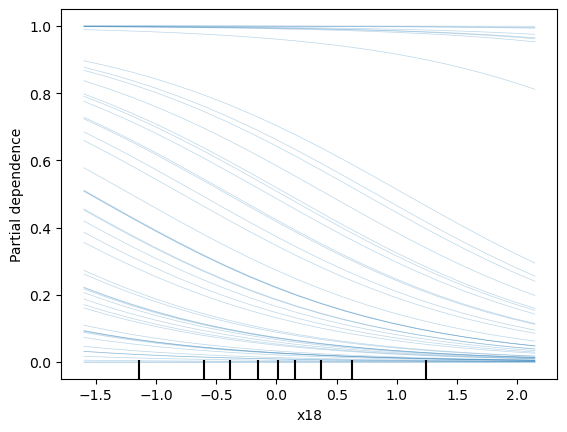

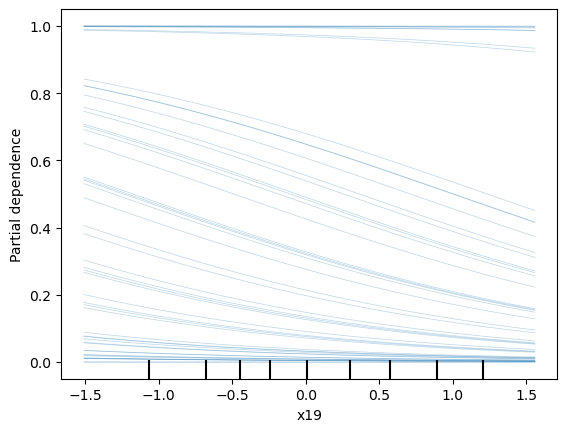

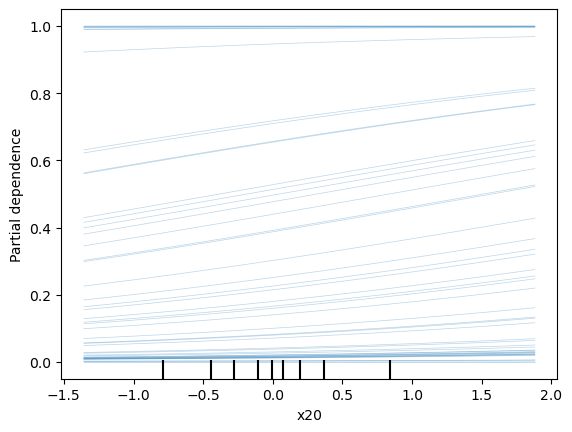

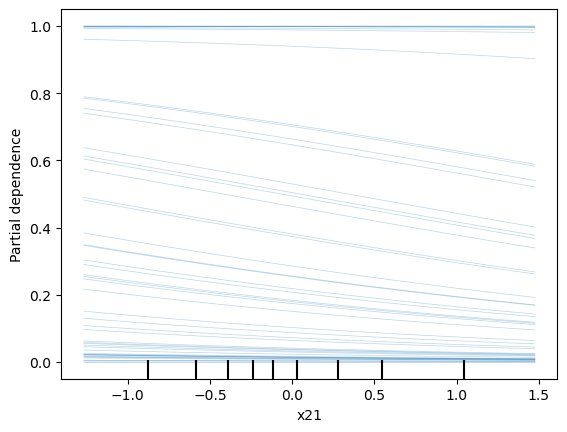

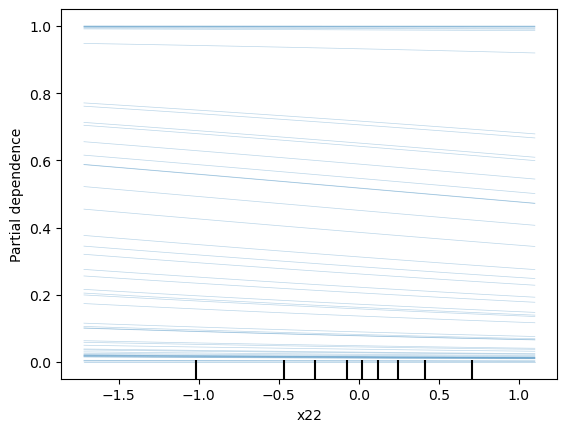

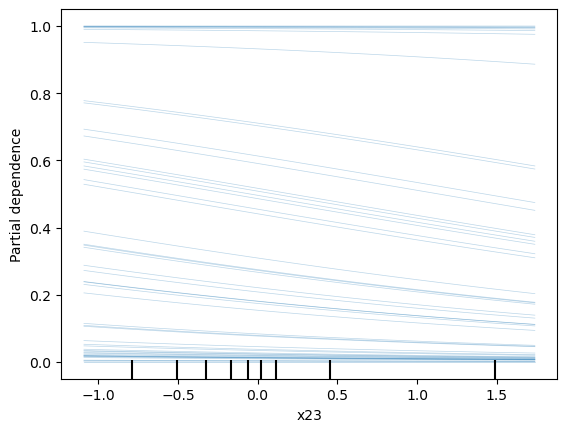

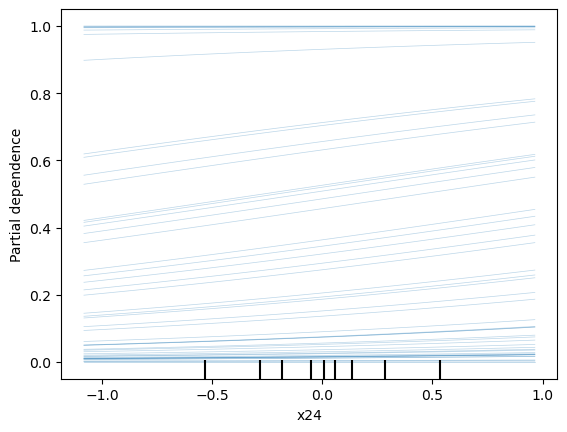

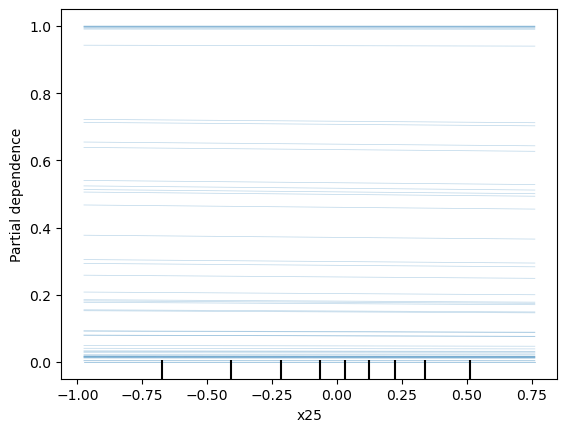

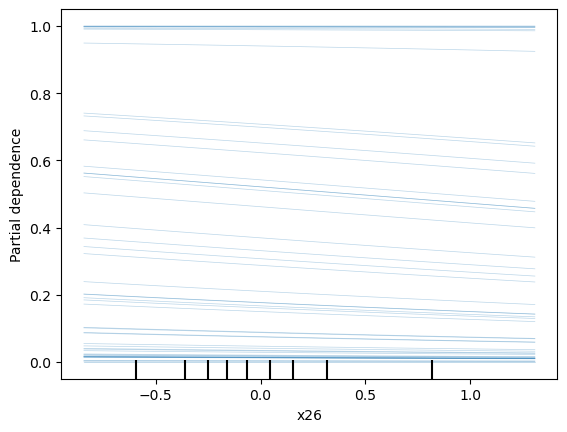

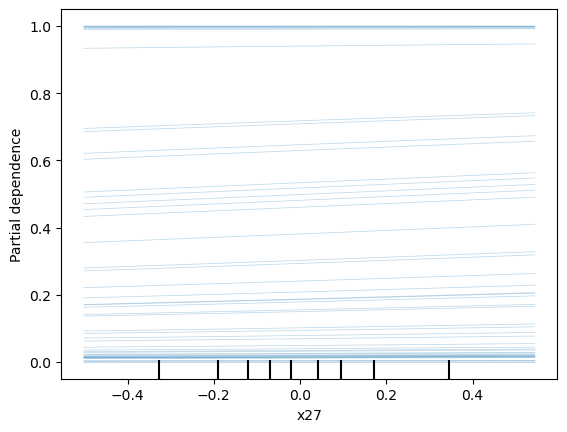

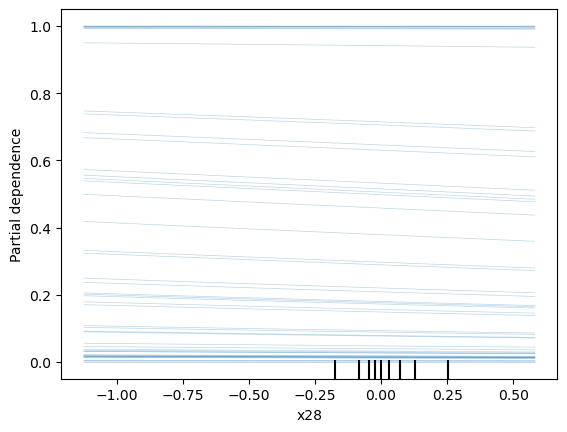

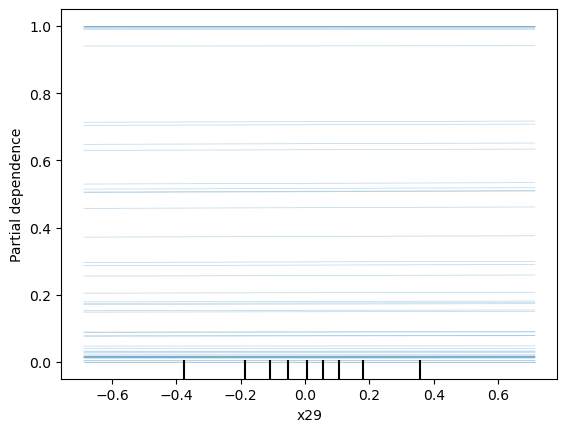

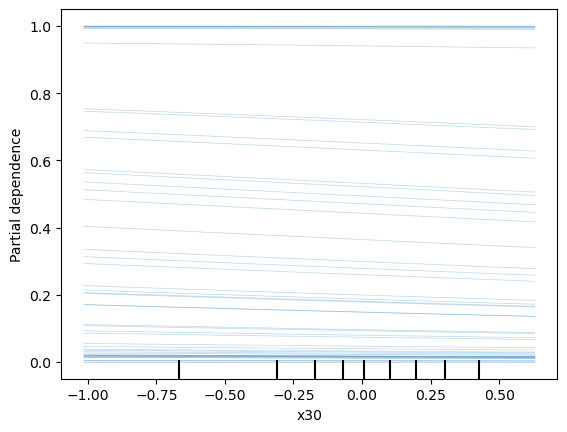

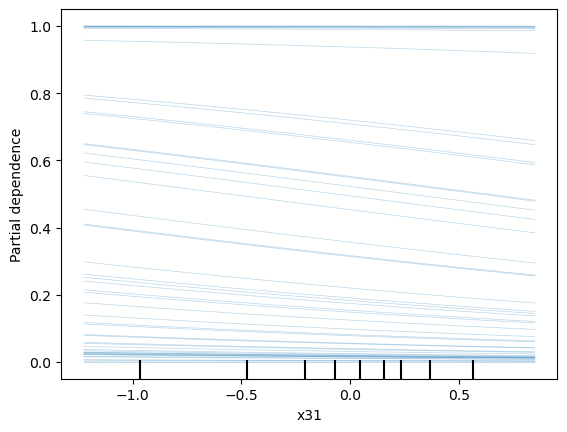

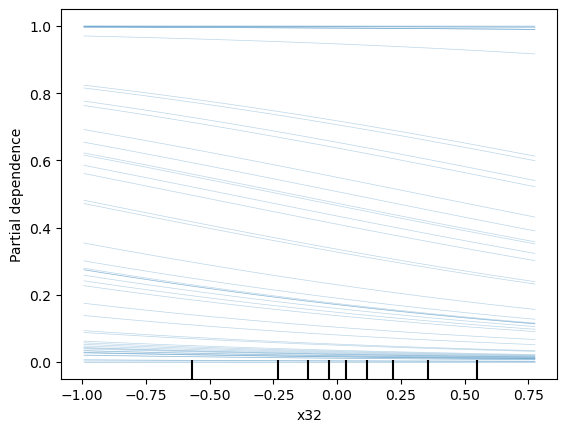

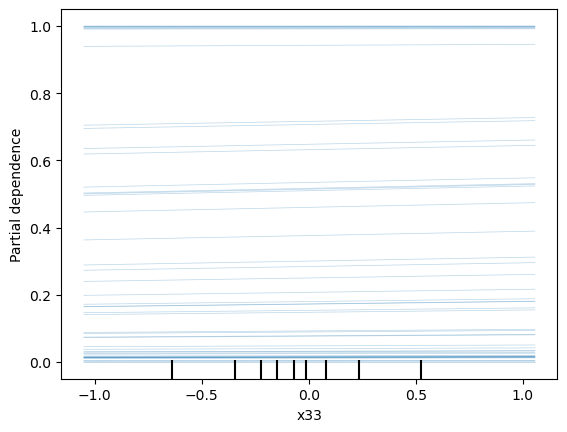

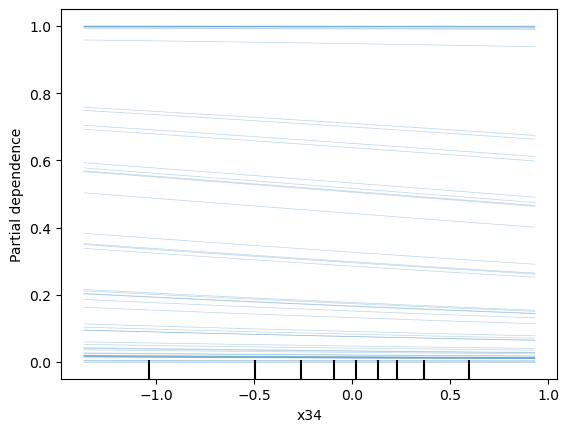

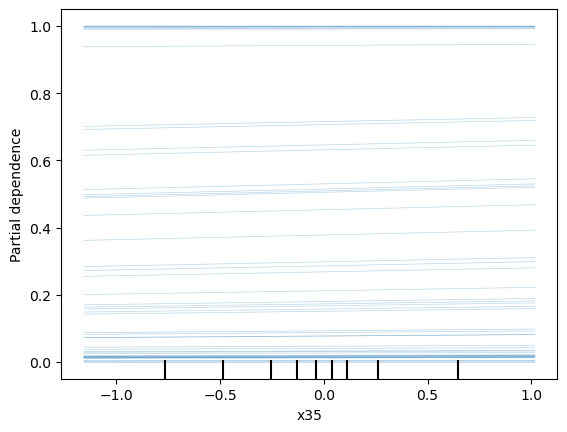

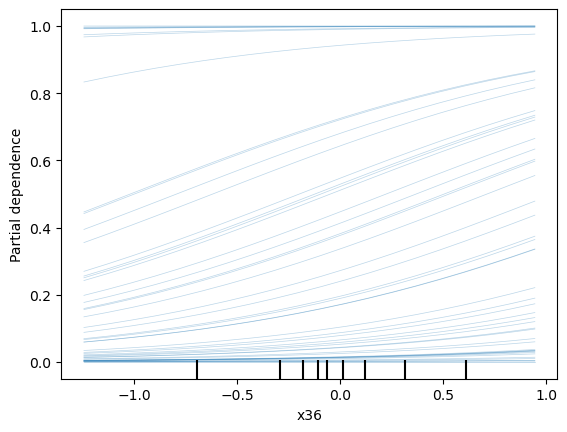

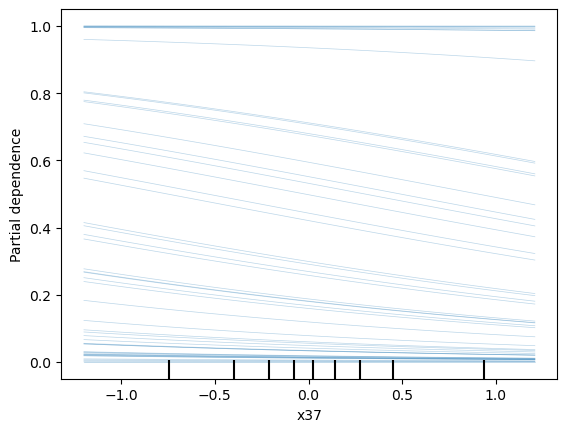

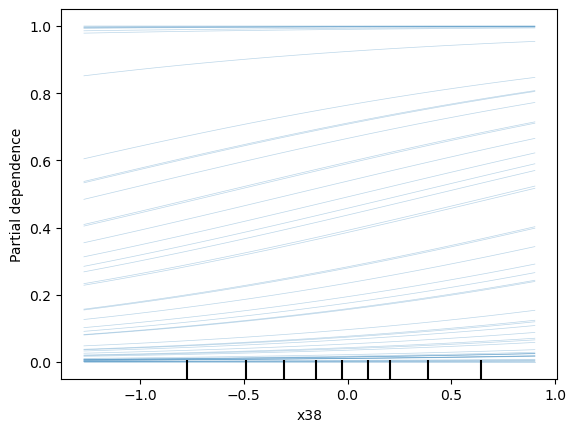

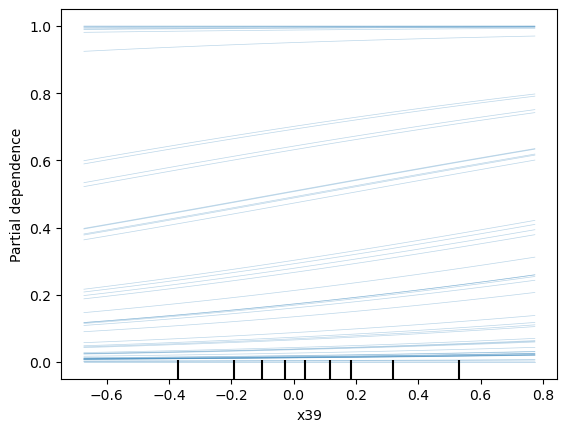

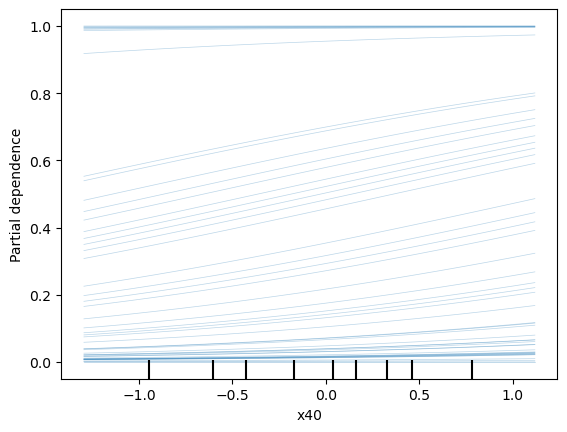

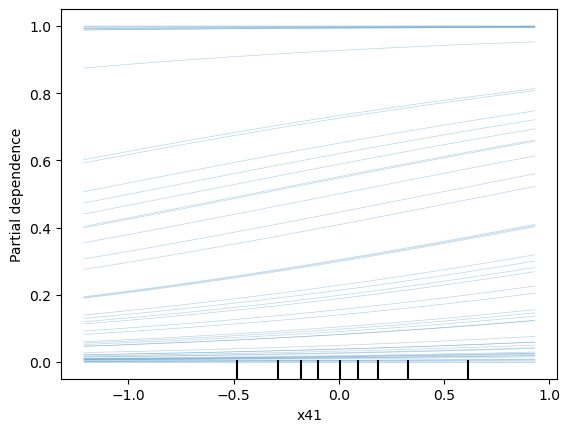

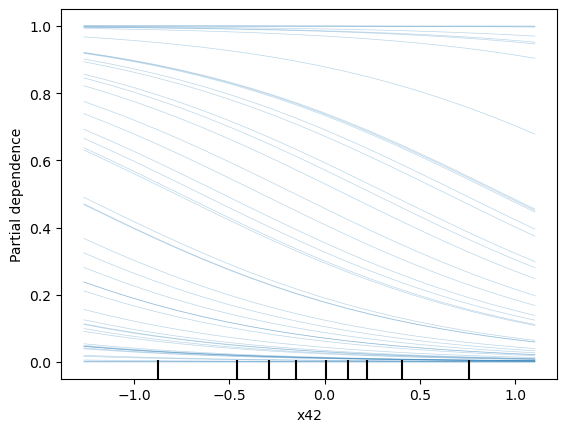

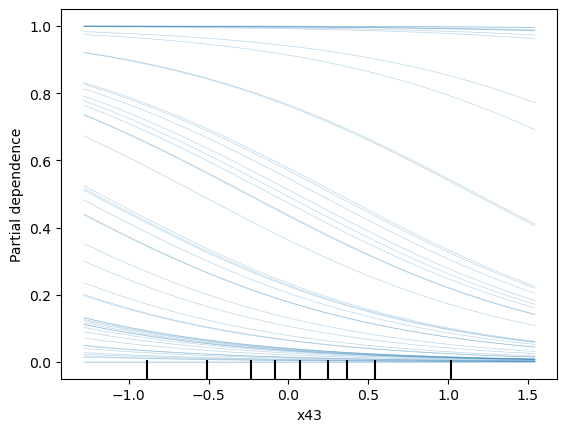

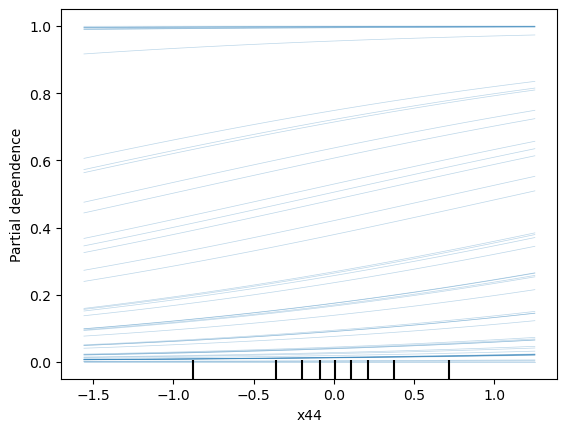

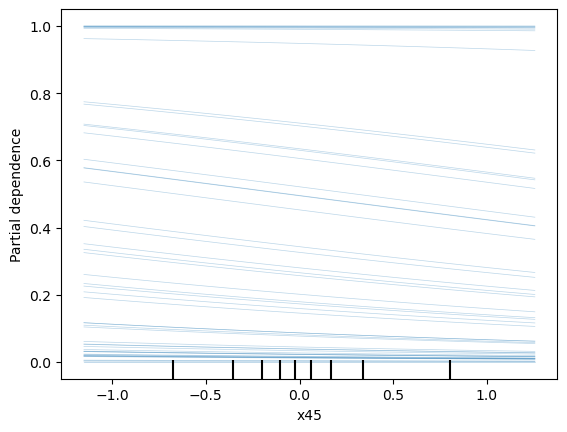

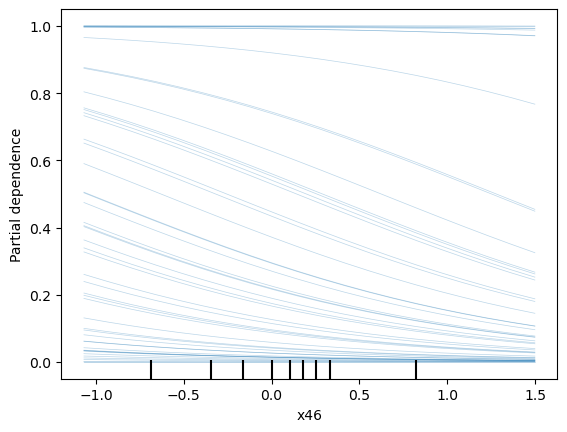

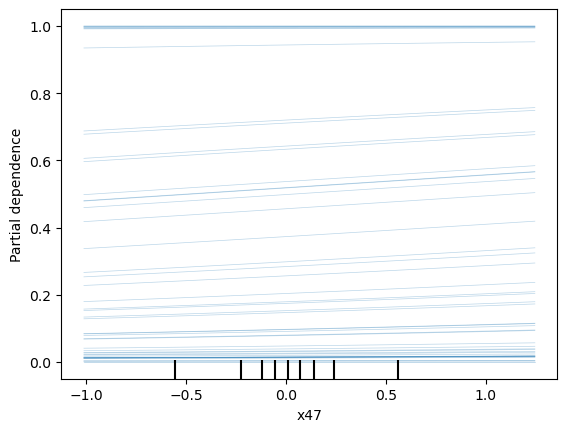

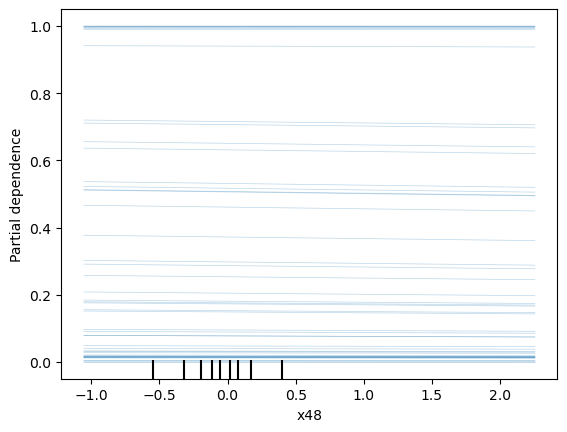

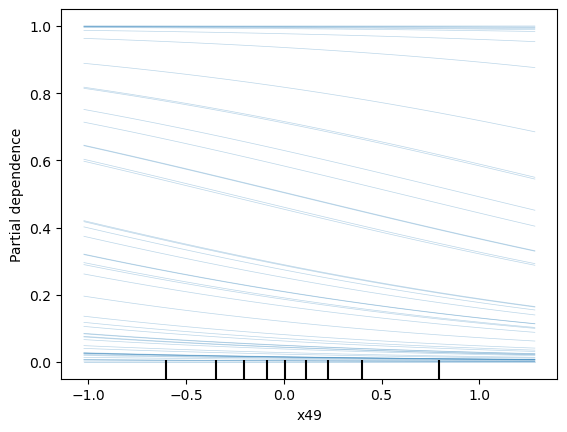

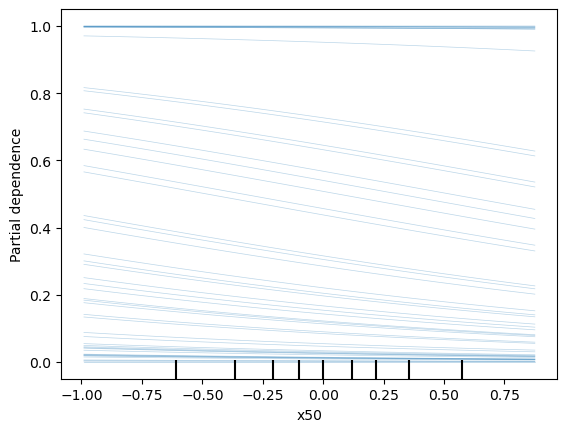

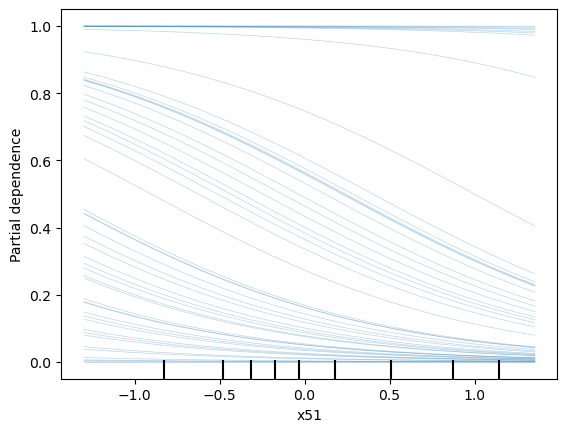

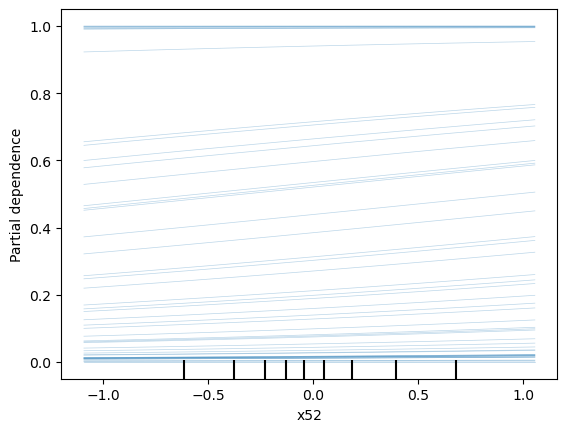

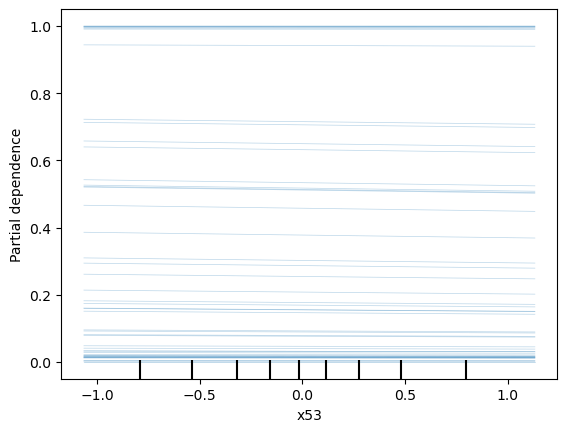

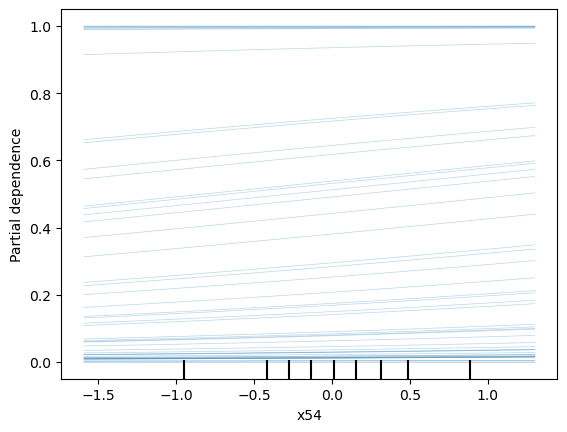

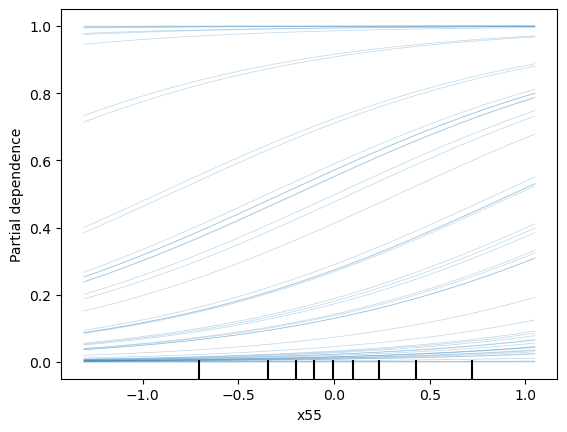

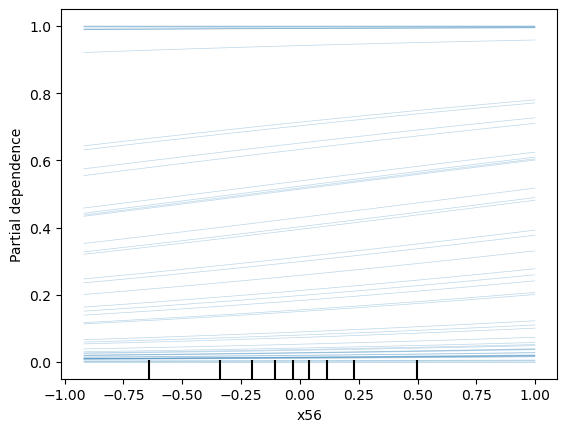

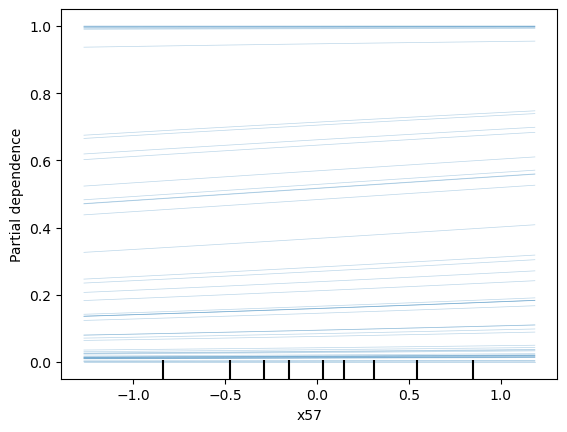

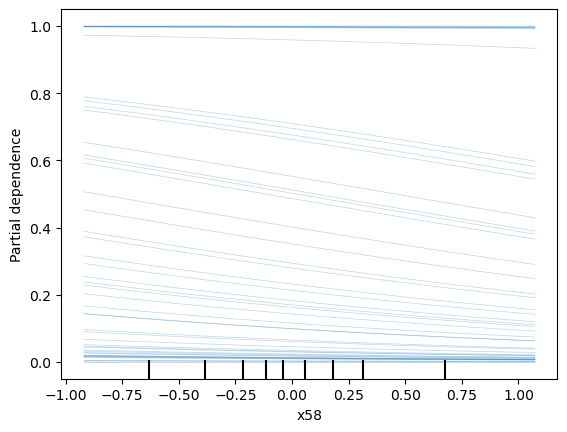

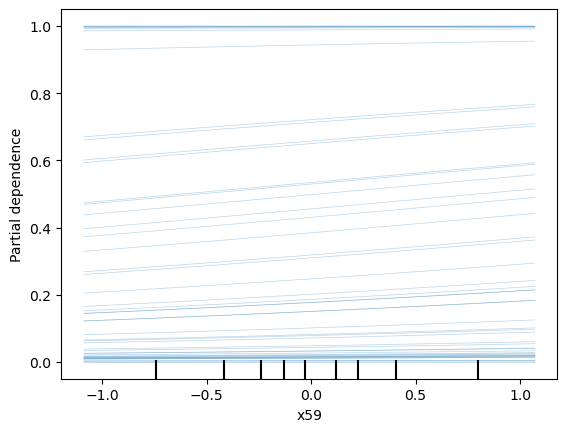

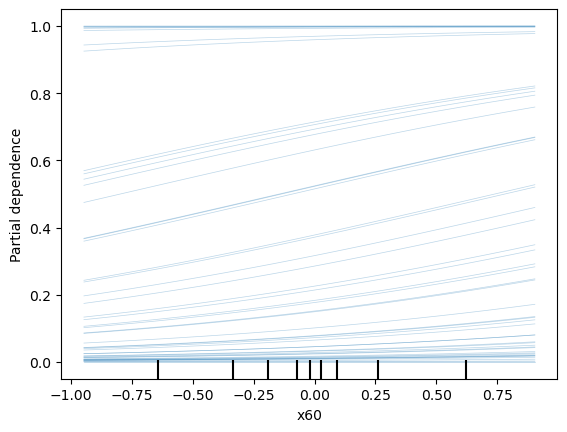

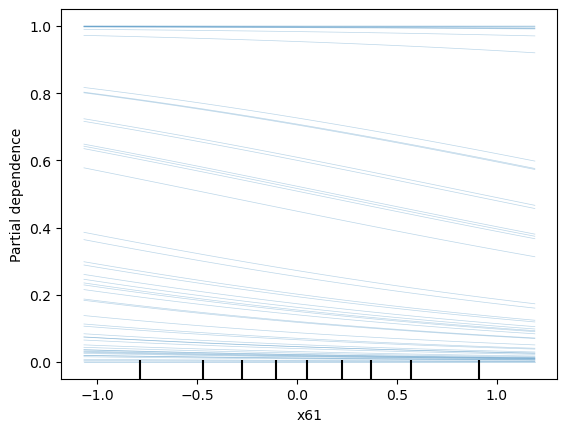

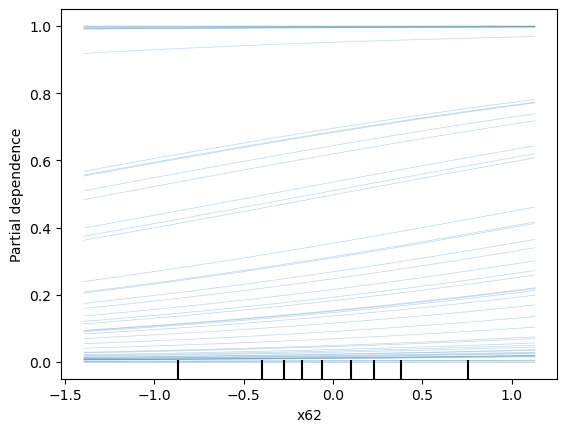

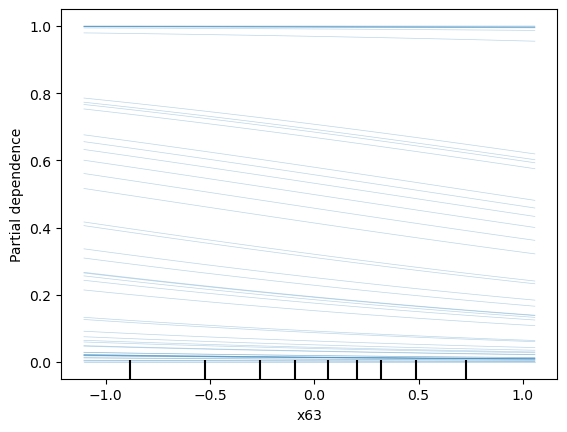

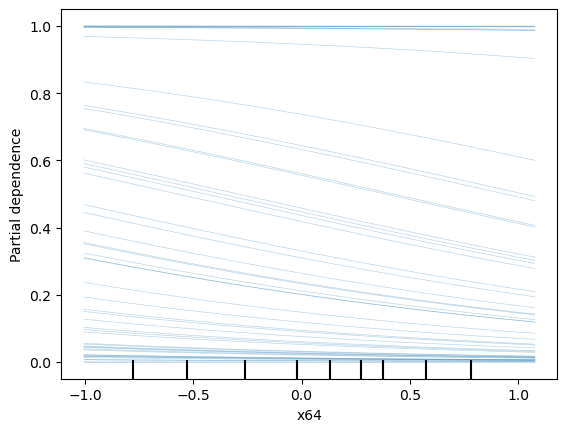

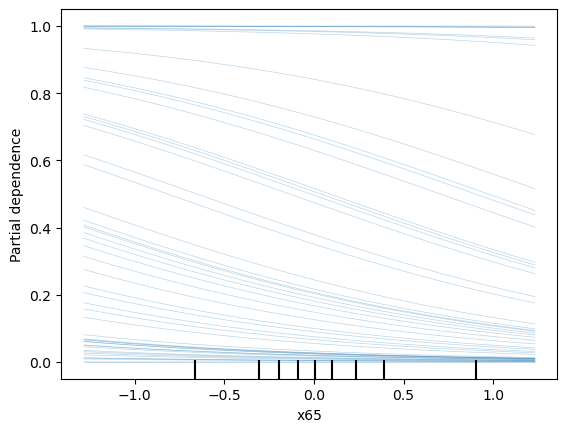

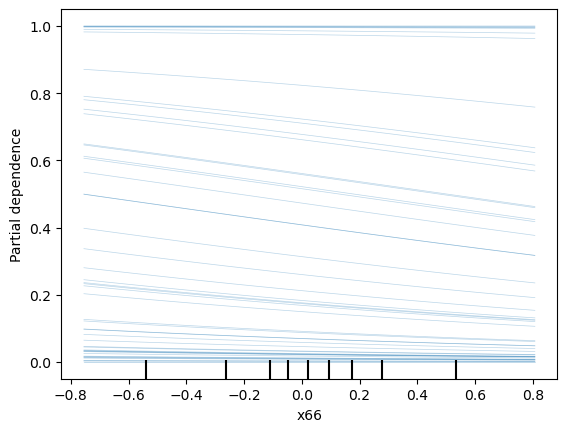

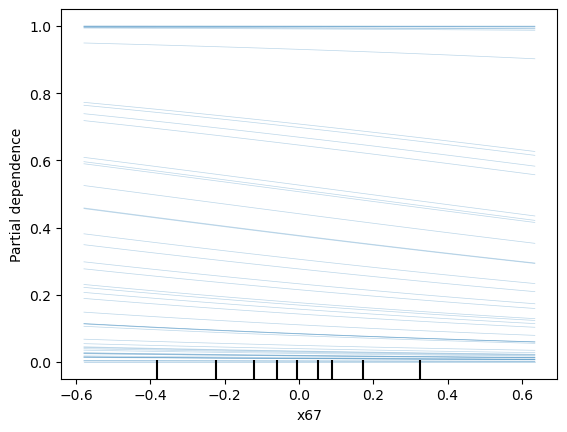

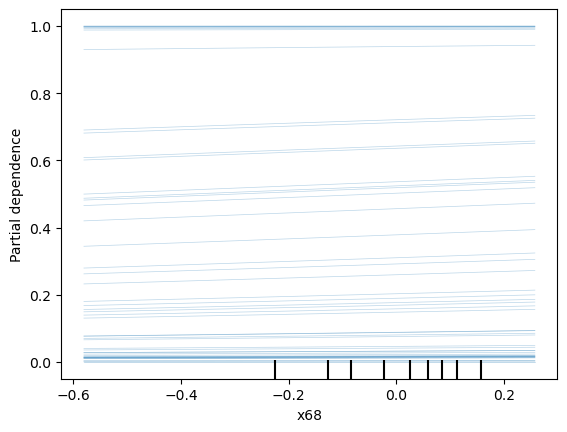

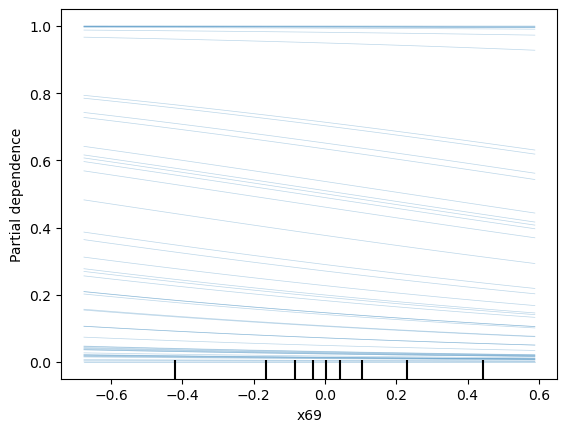

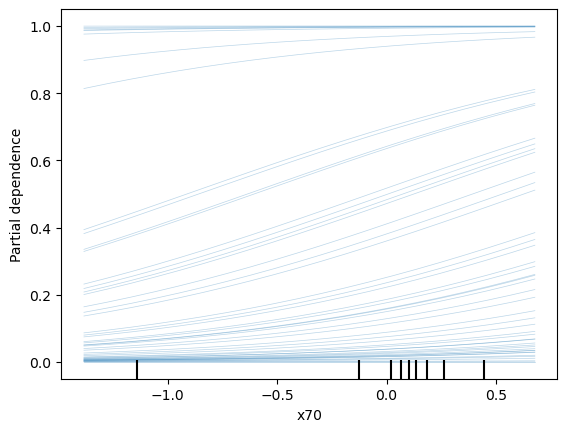

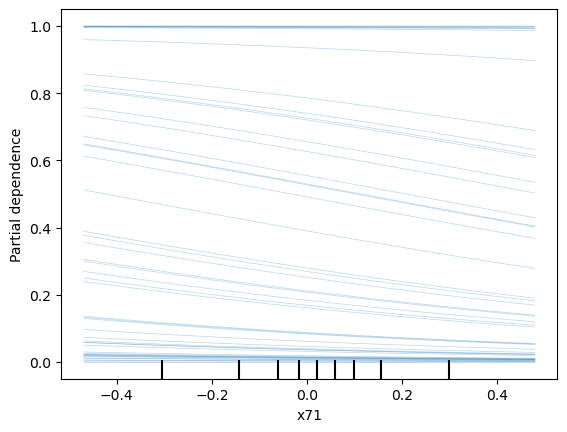

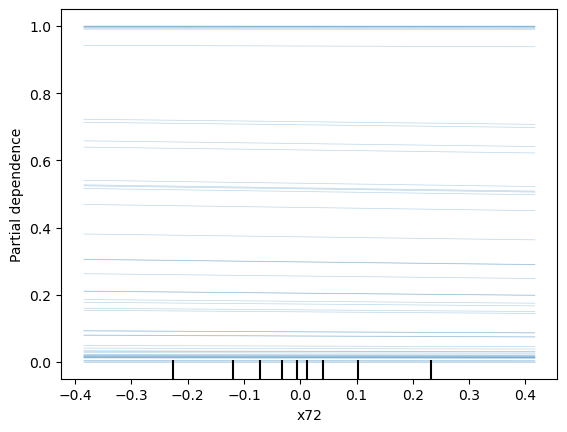

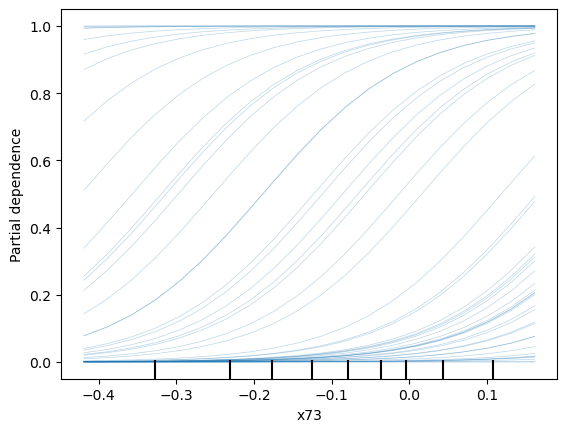

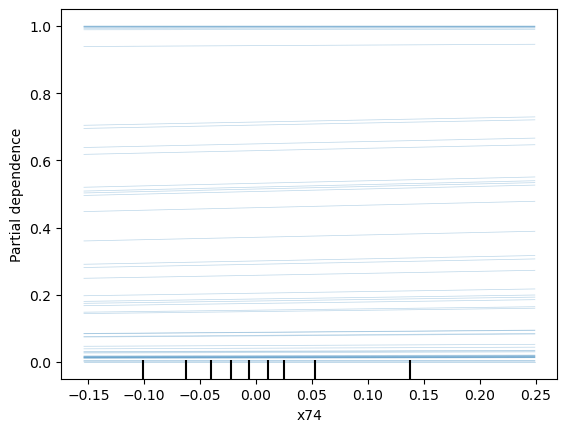

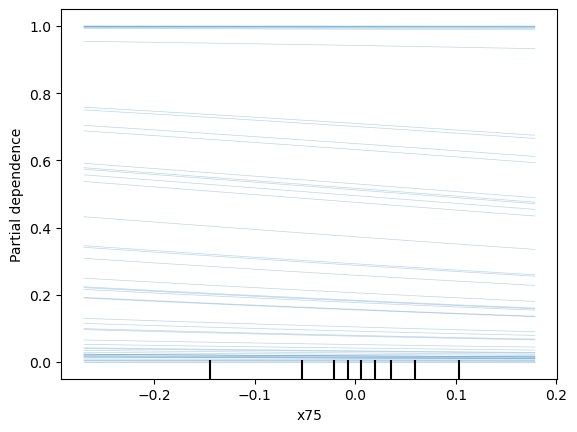

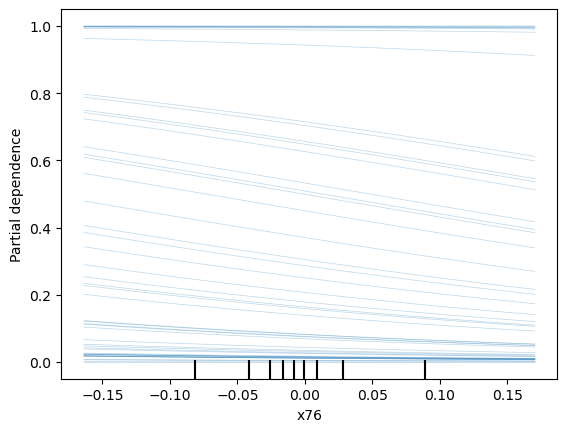

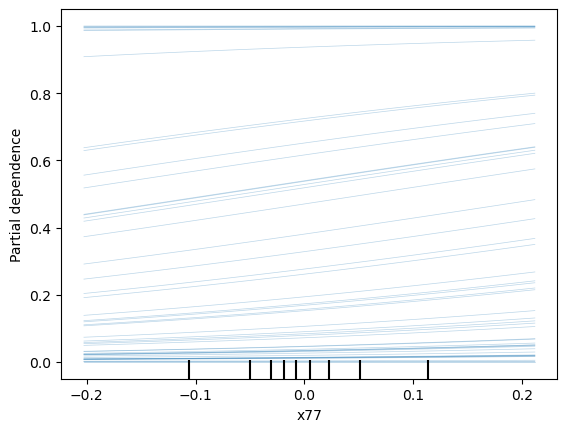

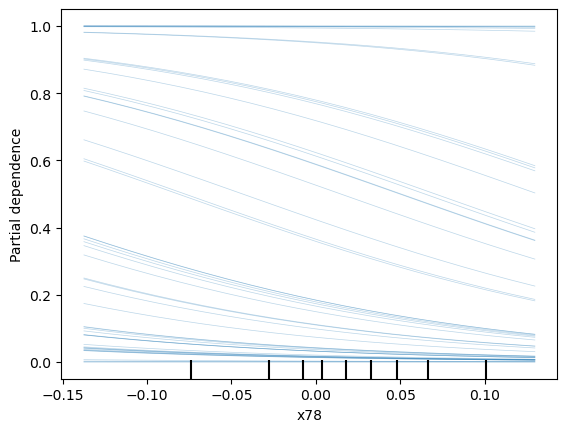

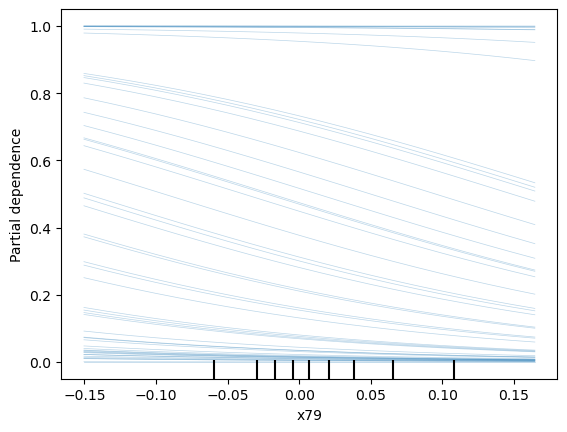

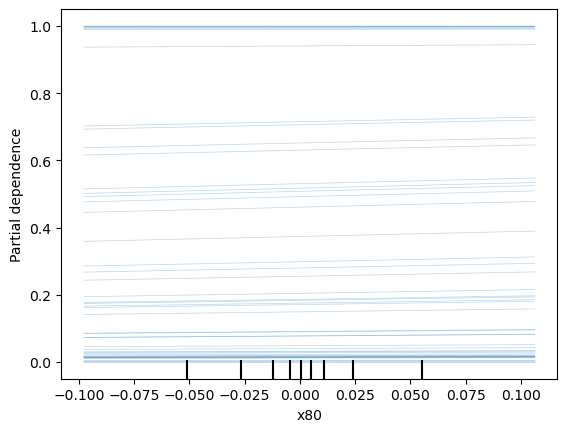

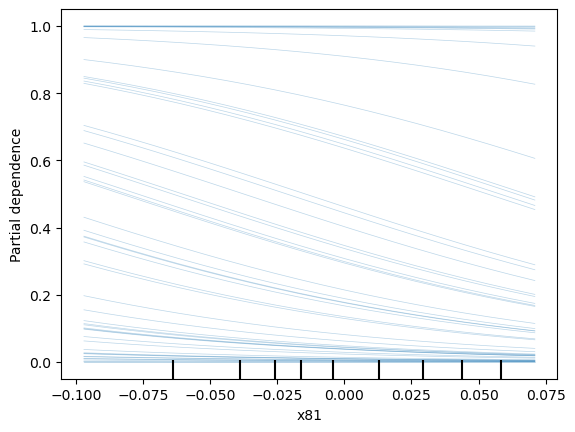

In [27]:
# Display partial dependence plot for each PCA feature
for component in range(X_transformed.shape[1]):
    display = PartialDependenceDisplay.from_estimator(
        final_pipeline.named_steps['classifier'],
        X_transformed,
        features=[component],
        kind="individual",
        subsample=50,
        grid_resolution=20,
        random_state=42
    )
    plt.show()